In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd
import itertools
import calendar

# ESIO Imports

from esio import EsioData as ed
from esio import ice_plot
from esio import metrics

import dask
dask.set_options(get=dask.threaded.get)
# from dask.distributed import Client, progress
# client = Client(processes=12)

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams.update({'figure.max_open_warning': 0})

#############################################################
# Load in Data
#############################################################
E = ed.EsioData.load()
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'metrics', 'extent')

In [2]:
ds_region = xr.open_mfdataset(os.path.join(E.grid_dir, 'sio_2016_mask_Update.nc'))

In [3]:
out_dir = '/home/disk/sipn/nicway/data/Director_data/RPackage/SIPN'

In [4]:
mod_adj_f = 'Mod_adj_test.nc'
ds_mod_adj = xr.open_dataset(os.path.join(out_dir,mod_adj_f))
ds_mod_adj

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, year: 1)
Coordinates:
  * year     (year) int32 31
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    iceInd   (lat, lon, year) float32 ...

In [5]:
mod_f = 'Mod_test.nc'
ds_mod = xr.open_dataset(os.path.join(out_dir,mod_f))
ds_mod

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, months: 43, years: 135)
Coordinates:
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * years    (years) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lon      (lon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    iceInd   (lat, lon, months, years) float64 ...

In [6]:
obs_f = 'Obs_test.nc'
ds_obs = xr.open_dataset(os.path.join(out_dir,obs_f))
ds_obs

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, months: 43, years: 135)
Coordinates:
  * months   (months) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * lon      (lon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * years    (years) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Data variables:
    conc     (lat, lon, months, years) float64 ...

In [7]:
# Select "month" (forecast day lead time) and "year" (initilization day) to plot
cmonth = 43
cpyear = 31

In [8]:
ds_mod_adj

<xarray.Dataset>
Dimensions:  (lat: 448, lon: 304, year: 1)
Coordinates:
  * year     (year) int32 31
  * lon      (lon) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * lat      (lat) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Data variables:
    iceInd   (lat, lon, year) float32 ...

### Bias correction of the 43 day forecast, using the past 31 days of initialization forecasts
### (not operationaly applicable, uses future obs)

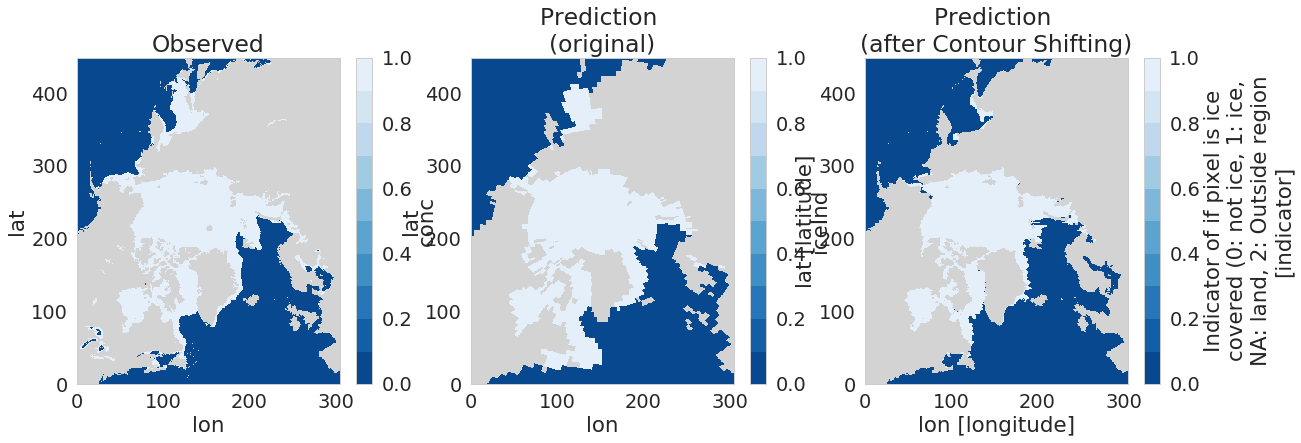

In [9]:
# Compare obs, model, adjusted model
f = plt.figure(figsize=((20,6)))

cmap_c = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_c.set_bad(color = 'lightgrey')

plt.subplot(1,3,1)
c_O = ds_obs.sel(years=cpyear, months=cmonth).conc
c_O = ((c_O>=15) & (c_O<=100)).where(ds_obs.sel(years=cpyear, months=cmonth).conc<=100)
c_O.plot(cmap=cmap_c)
plt.title('Observed')

plt.subplot(1,3,2)
c_M = ds_mod.sel(years=cpyear, months=cmonth).iceInd
(c_M>0.15).where(c_M.notnull()).plot(cmap=cmap_c)
plt.title('Prediction \n(original)')

plt.subplot(1,3,3)
c_M_a = ds_mod_adj.sel(year=cpyear).iceInd
cmask = c_M_a.notnull()
c_M_a = c_M_a.where(c_M_a<=1, other=0)
c_M_a = c_M_a.where(cmask)
c_M_a.plot(cmap=cmap_c)

plt.title('Prediction \n(after Contour Shifting)')
f.savefig('CS_test.png')

## Evaluate 

In [10]:
# PanArctic Extent


In [11]:
# IIEE


# Calcualte sea ice presence from obs and model
obs_sip = ds_obs.sel(years=cpyear, months=cmonth).conc
obs_sip = ((obs_sip>=15) & (obs_sip<=100)).where(ds_obs.sel(years=cpyear, months=cmonth).conc<=100)
obs_sip = obs_sip.rename({'lat':'y','lon':'x'})

mod_sip = ds_mod.sel(years=cpyear, months=cmonth).iceInd
mod_sip = (mod_sip>0.15).where(mod_sip.notnull())
mod_sip = mod_sip.rename({'lat':'y','lon':'x'})

mod_sip_adj = ds_mod_adj.sel(year=cpyear).iceInd
cmask = mod_sip_adj.notnull()
mod_sip_adj = mod_sip_adj.where(c_M_a<=1, other=0)
mod_sip_adj = mod_sip_adj.where(cmask)
mod_sip_adj = mod_sip_adj.rename({'lat':'y','lon':'x'})

# "flip" lat/y coordiant (CS and SIPN have different orientation)
ds_region['mask'] = xr.DataArray(np.flip(ds_region.mask.values, axis=1), dims = ds_region.mask.dims, coords = ds_region.mask.coords)
ds_region['area'] = xr.DataArray(np.flip(ds_region.area.values, axis=1), dims = ds_region.area.dims, coords = ds_region.area.coords)
ds_region['hole_mask'] = xr.DataArray(np.flip(ds_region.hole_mask.values, axis=1), dims = ds_region.hole_mask.dims, coords = ds_region.hole_mask.coords)


### Original Model IIEE

In [14]:
%autoreload
c_IIEE_orig = metrics.IIEE(da_mod=mod_sip, da_obs=obs_sip, region=ds_region, sic_threshold=0.15)
c_IIEE_orig.values # km^2

array(2.11446735)

### Original Model IIEE

In [15]:
c_IIEE_adj = metrics.IIEE(da_mod=mod_sip_adj, da_obs=obs_sip, region=ds_region, sic_threshold=0.15)
c_IIEE_adj.values # km^2

array(1.90314647)

In [16]:
### Percent IIEE Reductoin

In [17]:
(c_IIEE_adj.values-c_IIEE_orig.values)/c_IIEE_orig.values*100

-9.994048043684026